In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel, convert_to_peft
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config


In [30]:
# Load configuration
config = load_config('eval_config.json')

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and processor
pretrained_name = config['pretrained_name']
vit_config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)

# Get image normalization parameters
img_mean = processor.image_mean
img_std = processor.image_std

# Target model for explanation
target_model = ViTForImageClassification.from_pretrained(pretrained_name)
target_model.eval()
target_model.to(device)

# Load trained weights
maskgen_model = MaskGeneratingModel.load_model(base_model_name=pretrained_name, 
                                save_path=config['model_path'], 
                                hidden_size=vit_config.hidden_size, 
                                num_classes=vit_config.num_labels)
maskgen_model.eval()
maskgen_model.to(device)

print() 

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

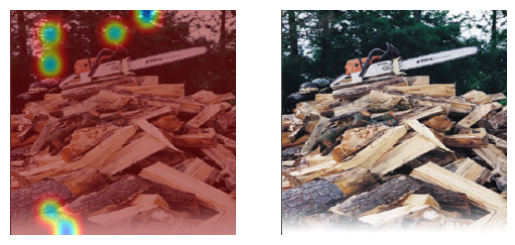

In [31]:
import requests
from PIL import Image
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

dist, value, _ = maskgen_model.get_dist_critic(img, label.unsqueeze(1))
sim_logits = dist.logits
N = inputs['pixel_values'].shape[0]
size = 14

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = maskgen_model.attribute_img(img, label.unsqueeze(1), image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, img_mean, img_std)

In [23]:
torch.sigmoid(sim_logits).reshape(N, size, size)

tensor([[[0.9770, 0.9632, 0.9450, 0.9837, 0.9630, 0.9659, 0.9667, 0.9590,
          0.9824, 0.9830, 0.9714, 0.9659, 0.9813, 0.9800],
         [0.9653, 0.9799, 0.9566, 0.9779, 0.9939, 0.9655, 0.9828, 0.9608,
          0.9399, 0.9758, 0.8161, 0.9751, 0.9710, 0.9871],
         [0.9735, 0.9715, 0.9678, 0.9979, 0.9962, 0.9714, 0.9576, 0.8807,
          0.8653, 0.8817, 0.9370, 0.8525, 0.9488, 0.4408],
         [0.9870, 0.9715, 0.9687, 0.4414, 0.9924, 0.9713, 0.9674, 0.9393,
          0.8720, 0.8118, 0.7311, 0.8846, 0.9643, 0.9713],
         [0.9540, 0.4494, 0.9415, 0.9770, 0.9863, 0.9720, 0.9861, 0.8042,
          0.6459, 0.7518, 0.9185, 0.8160, 0.9674, 0.9653],
         [0.9675, 0.9910, 0.9811, 0.9602, 0.9809, 0.9562, 0.9604, 0.6623,
          0.7735, 0.9519, 0.6565, 0.9629, 0.9593, 0.9465],
         [0.9616, 0.9801, 0.4404, 0.9852, 0.9894, 0.9911, 0.9443, 0.7807,
          0.7417, 0.7296, 0.8140, 0.9467, 0.9578, 0.9859],
         [0.9949, 0.9940, 0.9994, 0.9989, 0.9993, 0.9996, 0.9703, 0.7